In [1]:
from __future__ import print_function
from __future__ import division

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context(rc={'figure.figsize': (14, 7) } )
figzize_me = figsize =(14, 7)
# import warnings; 
# warnings.filterwarnings('ignore')

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy
# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/csv


# 第10章 量化系统-机器学习•猪老三 

[abu量化系统github地址](https://github.com/bbfamily/abu) (您的star是我的动力！)

[abu量化文档教程ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

## 10.2 猪老三世界中的量化环境

In [2]:
"""
    是否开启date_week噪音, 开启这个的目的是让分类结果正确率降低，接近真实
"""
g_with_date_week_noise = False

In [3]:
from abupy import ABuSymbolPd

def _gen_another_word_price(kl_another_word):
    """
    生成股票在另一个世界中的价格
    :param kl_another_word:
    :return:
    """
    for ind in np.arange(2, kl_another_word.shape[0]):
        # 前天数据
        bf_yesterday = kl_another_word.iloc[ind - 2]
        # 昨天
        yesterday = kl_another_word.iloc[ind - 1]
        # 今天
        today = kl_another_word.iloc[ind]
        # 生成今天的收盘价格
        kl_another_word.close[ind] = _gen_another_word_price_rule(
            yesterday.close, yesterday.volume,
            bf_yesterday.close, bf_yesterday.volume,
            today.volume, today.date_week)


def _gen_another_word_price_rule(yesterday_close, yesterday_volume,
                                 bf_yesterday_close,
                                 bf_yesterday_volume,
                                 today_volume, date_week):
    """
        通过前天收盘量价，昨天收盘量价，今天的量，构建另一个世界中的价格模型
    """
    # 昨天收盘价格与前天收盘价格的价格差
    price_change = yesterday_close - bf_yesterday_close
    # 昨天成交量与前天成交量的量差
    volume_change = yesterday_volume - bf_yesterday_volume

    # 如果量和价变动一致，今天价格涨，否则跌
    # 即量价齐涨－>涨, 量价齐跌－>涨，量价不一致－>跌
    sign = 1.0 if price_change * volume_change > 0 else -1.0
    
    # 通过date_week生成噪音，否则之后分类100%分对
    if g_with_date_week_noise:
        # 针对sign生成噪音，噪音的生效的先决条件是今天的量是这三天最大的
        gen_noise = today_volume > np.max(
            [yesterday_volume, bf_yesterday_volume])
        # 如果量是这三天最大 且是周五，下跌
        if gen_noise and date_week == 4:
            sign = -1.0
        # 如果量是这三天最大，如果是周一，上涨
        elif gen_noise and date_week == 0:
            sign = 1.0

    # 今天的涨跌幅度基础是price_change（昨天前天的价格变动）
    price_base = abs(price_change)
    # 今天的涨跌幅度变动因素：量比，
    # 今天的成交量/昨天的成交量 和 今天的成交量/前天的成交量 的均值
    price_factor = np.mean([today_volume / yesterday_volume,
                            today_volume / bf_yesterday_volume])

    if abs(price_base * price_factor) < yesterday_close * 0.10:
        # 如果 量比 * price_base 没超过10%，今天价格计算
        today_price = yesterday_close + \
                      sign * price_base * price_factor
    else:
        # 如果涨跌幅度超过10%，限制上限，下限为10%
        today_price = yesterday_close + sign * yesterday_close * 0.10
    return today_price


def change_real_to_another_word(symbol):
    """
    将原始真正的股票数据价格列只保留前两天数据，成交量，周几列完全保留
    价格列其他数据使用_gen_another_word_price变成另一个世界价格
    :param symbol:
    :return:
    """
    kl_pd = ABuSymbolPd.make_kl_df(symbol)
    if kl_pd is not None:
        # 原始股票数据也只保留价格，周几，成交量
        kl_pig_three = kl_pd.filter(['close', 'date_week', 'volume'])
        # 只保留原始头两天的交易收盘价格，其他的的都赋予nan
        kl_pig_three['close'][2:] = np.nan
        # 将其他nan价格变成猪老三世界中价格使用_gen_another_word_price
        _gen_another_word_price(kl_pig_three)
        return kl_pig_three

In [7]:
choice_symbols = ['usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG',
                  'usTSLA', 'usWUBA', 'usVIPS']
another_word_dict = {}
real_dict = {}
for symbol in choice_symbols:
    # 猪老三世界的股票走势字典
    another_word_dict[symbol] = change_real_to_another_word(symbol)
    # 真实世界的股票走势字典，这里不考虑运行效率问题
    real_dict[symbol] = ABuSymbolPd.make_kl_df(symbol)
# 表10-1所示
another_word_dict['usNOAH'].head()

,close,date_week,volume
2014-07-24,15.2100,3,307211
2014-07-25,15.3200,4,101442
2014-07-28,14.8861,0,601568
2014-07-29,13.3975,1,655297
2014-07-30,12.5709,2,348344


In [8]:
# 表10-2所示
real_dict['usNOAH'].head().filter(['close', 'date_week', 'volume'])

,close,date_week,volume
2014-07-24,15.21,3,307211
2014-07-25,15.32,4,101442
2014-07-28,16.13,0,601568
2014-07-29,16.75,1,655297
2014-07-30,16.83,2,348344


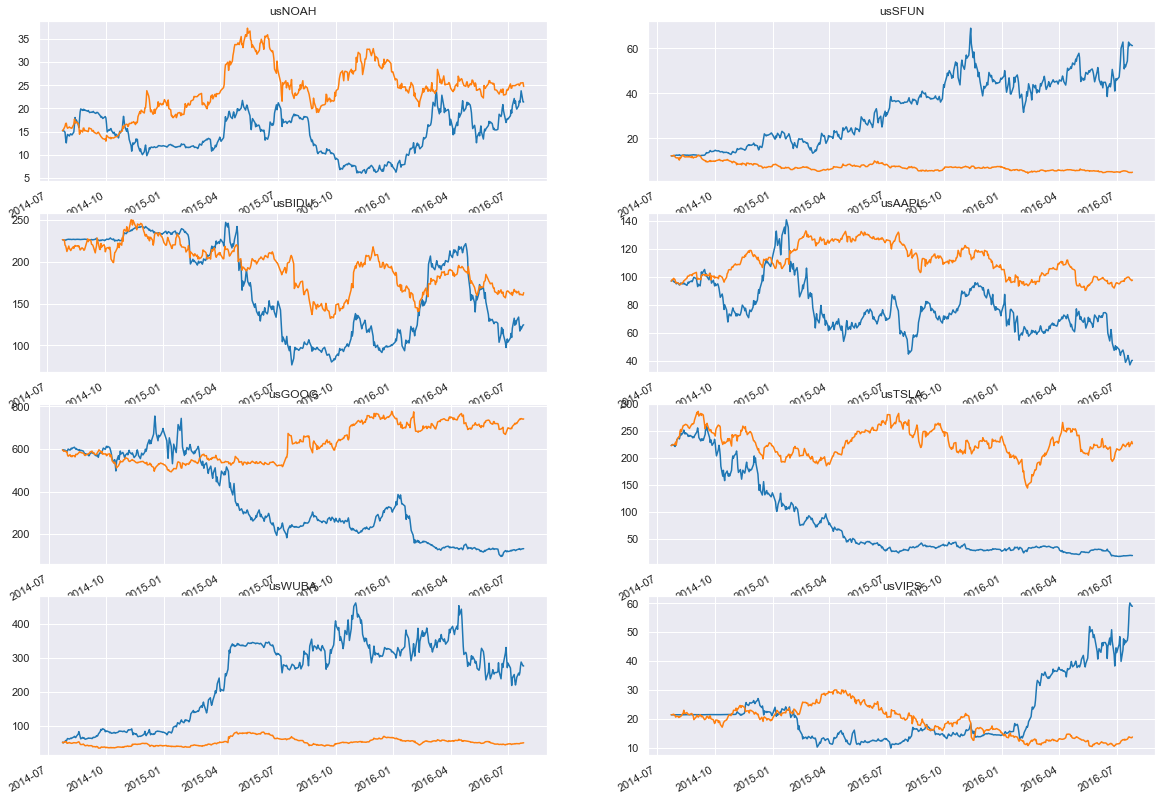

In [9]:
import itertools
# 4 ＊ 2
_, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))
# 将画布序列拉平
axs_list = list(itertools.chain.from_iterable(axs))

for symbol, ax in zip(choice_symbols, axs_list):
    # 绘制猪老三世界的股价走势
    another_word_dict[symbol].close.plot(ax=ax)
    # 同样的股票在真实世界的股价走势
    real_dict[symbol].close.plot(ax=ax)
    ax.set_title(symbol)

## 10.3 有监督机器学习

In [10]:
import sklearn.preprocessing as preprocessing

def gen_pig_three_feature(kl_another_word):
    """
    猪老三构建特征模型函数
    :param kl_another_word: 即上一节使用_gen_another_word_price
    生成的dataframe有收盘价，周几，成交量列
    :return:
    """
    # y值使用close.pct_change即涨跌幅度
    kl_another_word['regress_y'] = kl_another_word.close.pct_change()
    # 前天收盘价格
    kl_another_word['bf_yesterday_close'] = 0
    # 昨天收盘价格
    kl_another_word['yesterday_close'] = 0
    # 昨天收盘成交量
    kl_another_word['yesterday_volume'] = 0
    # 前天收盘成交量
    kl_another_word['bf_yesterday_volume'] = 0

    # 对齐特征，前天收盘价格即与今天的收盘错2个时间单位，[2:] = [:-2]
    kl_another_word['bf_yesterday_close'][2:] = \
        kl_another_word['close'][:-2]
    # 对齐特征，前天成交量
    kl_another_word['bf_yesterday_volume'][2:] = \
        kl_another_word['volume'][:-2]
    # 对齐特征，昨天收盘价与今天的收盘错1个时间单位，[1:] = [:-1]
    kl_another_word['yesterday_close'][1:] = \
        kl_another_word['close'][:-1]
    # 对齐特征，昨天成交量
    kl_another_word['yesterday_volume'][1:] = \
        kl_another_word['volume'][:-1]

    # 特征1: 价格差
    kl_another_word['feature_price_change'] = \
        kl_another_word['yesterday_close'] - \
        kl_another_word['bf_yesterday_close']

    # 特征2: 成交量差
    kl_another_word['feature_volume_Change'] = \
        kl_another_word['yesterday_volume'] - \
        kl_another_word['bf_yesterday_volume']

    # 特征3: 涨跌sign
    kl_another_word['feature_sign'] = np.sign(
        kl_another_word['feature_price_change'] * kl_another_word[
            'feature_volume_Change'])

    # 特征4: 周几
    kl_another_word['feature_date_week'] = kl_another_word[
        'date_week']


    """
        构建噪音特征, 因为猪老三也不可能全部分析正确真实的特征因素
        这里引入一些噪音特征
    """
    # 成交量乘积
    kl_another_word['feature_volume_noise'] = \
        kl_another_word['yesterday_volume'] * \
        kl_another_word['bf_yesterday_volume']

    # 价格乘积
    kl_another_word['feature_price_noise'] = \
        kl_another_word['yesterday_close'] * \
        kl_another_word['bf_yesterday_close']

    # 将数据标准化
    scaler = preprocessing.StandardScaler()
    kl_another_word['feature_price_change'] = scaler.fit_transform(
        kl_another_word['feature_price_change'].values.reshape(-1, 1))
    kl_another_word['feature_volume_Change'] = scaler.fit_transform(
        kl_another_word['feature_volume_Change'].values.reshape(-1, 1))
    kl_another_word['feature_volume_noise'] = scaler.fit_transform(
        kl_another_word['feature_volume_noise'].values.reshape(-1, 1))
    kl_another_word['feature_price_noise'] = scaler.fit_transform(
        kl_another_word['feature_price_noise'].values.reshape(-1, 1))

    # 只筛选feature_开头的特征和regress_y，抛弃前两天数据，即[2:]
    kl_pig_three_feature = kl_another_word.filter(
        regex='regress_y|feature_*')[2:]
    return kl_pig_three_feature

In [11]:
pig_three_feature = None
for symbol in another_word_dict:
    # 首先拿出对应的走势数据
    kl_another_word = another_word_dict[symbol]
    # 通过走势数据生成训练集特征通过gen_pig_three_feature
    kl_feature = gen_pig_three_feature(kl_another_word)
    # 将每个股票的特征数据都拼接起来，形成训练集
    pig_three_feature = kl_feature if pig_three_feature is None \
        else pig_three_feature.append(kl_feature)

In [12]:
print(pig_three_feature.shape)
# 表10-3所示
pig_three_feature.tail()

(4016, 7)


,regress_y,feature_price_change,feature_volume_Change,feature_sign,feature_date_week,feature_volume_noise,feature_price_noise
2016-07-20,0.0893,1.0506,0.3134,1.0,2,-0.2249,2.6700
2016-07-21,0.1000,2.9096,0.6636,1.0,3,-0.1368,3.1299
2016-07-22,0.0283,3.5682,0.2452,1.0,4,0.0201,3.9368
2016-07-25,-0.0186,1.0562,-1.1699,-1.0,0,-0.1670,4.5766
2016-07-26,-0.0005,-0.8473,0.0221,-1.0,1,-0.2335,4.6274


### 10.3.1 猪老三使用回归预测股价

In [13]:
# Dataframe -> matrix
feature_np = pig_three_feature.as_matrix()
# x特征矩阵
train_x = feature_np[:, 1:]
# 回归训练的连续值y
train_y_regress = feature_np[:, 0]
# 分类训练的离散值y，之后分类技术使用
train_y_classification = np.where(train_y_regress > 0, 1, 0)

train_x[:5], train_y_regress[:5], train_y_classification[:5]

(array([[ 0.0656, -0.6043, -1.    ,  0.    , -0.3772,  0.0843],
        [-0.4635,  1.4642, -1.    ,  1.    , -0.3397,  0.0438],
        [-1.4896,  0.1561, -1.    ,  2.    ,  0.0787, -0.1895],
        [-0.8456, -0.9008,  1.    ,  3.    , -0.1297, -0.4425],
        [ 1.1248,  0.9107,  1.    ,  4.    , -0.1278, -0.4043]]),
 array([-0.0283, -0.1   , -0.0617,  0.0954,  0.0459]),
 array([0, 0, 0, 1, 1]))

In [14]:
def gen_feature_from_symbol(symbol):
    """
    封装由一个symbol转换为特征矩阵序列函数
    :param symbol:
    :return:
    """
    # 真实世界走势数据转换到老三的世界
    kl_another_word = change_real_to_another_word(symbol)
    # 由走势转换为特征dataframe通过gen_pig_three_feature
    kl_another_word_feature_test = \
        gen_pig_three_feature(kl_another_word)
    # 转换为matrix
    feature_np_test = kl_another_word_feature_test.as_matrix()
    # 从matrix抽取y回归
    test_y_regress = feature_np_test[:, 0]
    # y回归 －> y分类
    test_y_classification = np.where(test_y_regress > 0, 1, 0)
    # 从matrix抽取x特征矩阵
    test_x = feature_np_test[:, 1:]
    return test_x, test_y_regress, test_y_classification, \
           kl_another_word_feature_test

test_x, test_y_regress, test_y_classification, \
    kl_another_word_feature_test = gen_feature_from_symbol('usFB')

LinearRegression RMSE: -0.026008335193572013


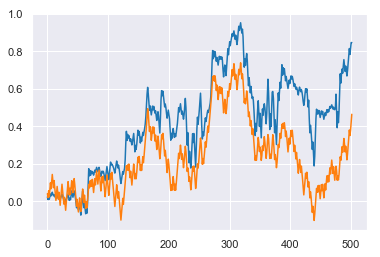

In [15]:
from sklearn.linear_model import LinearRegression
from abupy import cross_val_score
from abupy.CoreBu.ABuFixes import mean_squared_error_scorer


def regress_process(estimator, train_x, train_y_regress, test_x,
                    test_y_regress):
    # 训练训练集数据
    estimator.fit(train_x, train_y_regress)
    # 使用训练好的模型预测测试集对应的y，即根据usFB的走势特征预测股价涨跌幅度
    test_y_prdict_regress = estimator.predict(test_x)

    # 绘制usFB实际股价涨跌幅度
    plt.plot(test_y_regress.cumsum())
    # 绘制通过模型预测的usFB股价涨跌幅度
    plt.plot(test_y_prdict_regress.cumsum())

    # 针对训练集数据做交叉验证
    scores = cross_val_score(estimator, train_x, train_y_regress, cv=10, scoring=mean_squared_error_scorer)
    # mse开方 -> rmse
    mean_sc = -np.mean(np.sqrt(-scores))
    print('{} RMSE: {}'.format(estimator.__class__.__name__, mean_sc))


# 实例化线性回归对象estimator
estimator = LinearRegression()
# 将回归模型对象，训练集x，训练集连续y值，测试集x，测试集连续y传入
regress_process(estimator, train_x, train_y_regress, test_x,
                test_y_regress)

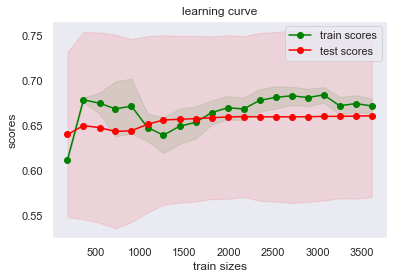

In [16]:
from abupy import ABuMLExecute
ABuMLExecute.plot_learning_curve(estimator, train_x, train_y_regress, cv=10)

Pipeline RMSE: -0.02444074685661418


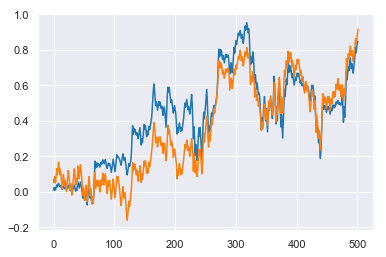

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# pipeline套上 degree=3 ＋ LinearRegression
estimator = make_pipeline(PolynomialFeatures(degree=3),
                          LinearRegression())
# 继续使用regress_process，区别是estimator变了
regress_process(estimator, train_x, train_y_regress, test_x,
                test_y_regress)

AdaBoostRegressor RMSE: -0.02363077139274753


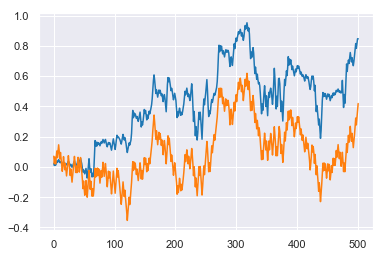

In [18]:
from sklearn.ensemble import AdaBoostRegressor

estimator = AdaBoostRegressor(n_estimators=100)
regress_process(estimator, train_x, train_y_regress, test_x,
                test_y_regress)

RandomForestRegressor RMSE: -0.019834560142606945


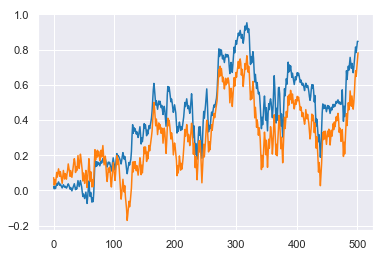

In [19]:
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor(n_estimators=100)
regress_process(estimator, train_x, train_y_regress, test_x, test_y_regress)

### 10.3.2 猪老三使用分类预测股票涨跌

#### 如果不添加噪音，分类预测正确率将是100%

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


def classification_process(estimator, train_x, train_y_classification,
                           test_x, test_y_classification):
    # 训练数据，这里分类要所以要使用y_classification
    estimator.fit(train_x, train_y_classification)
    # 使用训练好的分类模型预测测试集对应的y，即根据usFB的走势特征预测涨跌
    test_y_prdict_classification = estimator.predict(test_x)
    # 通过metrics.accuracy_score度量预测涨跌的准确率
    print("{} accuracy = {:.2f}".format(
        estimator.__class__.__name__,
        metrics.accuracy_score(test_y_classification,
                               test_y_prdict_classification)))

    # 针对训练集数据做交叉验证scoring='accuracy'，cv＝10
    scores = cross_val_score(estimator, train_x,
                             train_y_classification,
                             cv=10,
                             scoring='accuracy')
    # 所有交叉验证的分数取平均值
    mean_sc = np.mean(scores)
    print('cross validation accuracy mean: {:.2f}'.format(mean_sc))


estimator = LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
# 将分类器，训练集x，训练集y分类，测试集，测试集y分别传入函数
classification_process(estimator, train_x, train_y_classification,
                       test_x, test_y_classification)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWar

LogisticRegression accuracy = 0.93


/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarni

cross validation accuracy mean: 0.92


/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarni

## 1.0 将g_with_date_week_noise = True 添加噪音后重现生成数据

In [29]:
g_with_date_week_noise = True

choice_symbols = ['usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG', 'usTSLA', 'usWUBA', 'usVIPS']
another_word_dict = {}
real_dict = {}
for symbol in choice_symbols:
    another_word_dict[symbol] = change_real_to_another_word(symbol)
    real_dict[symbol] = ABuSymbolPd.make_kl_df(symbol)
pig_three_feature = None
for symbol in another_word_dict:
    kl_another_word = another_word_dict[symbol]
    kl_feature = gen_pig_three_feature(kl_another_word)
    pig_three_feature = kl_feature if pig_three_feature is None else pig_three_feature.append(kl_feature)

feature_np = pig_three_feature.as_matrix()
train_x = feature_np[:, 1:]
train_y_regress = feature_np[:, 0]
train_y_classification = np.where(train_y_regress > 0, 1, 0)
train_x[:5], train_y_regress[:5], train_y_classification[:5]
test_x, test_y_regress, test_y_classification, kl_another_word_feature_test = gen_feature_from_symbol('usFB')

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by Stand

## noise 0.93

In [30]:
estimator = LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
classification_process(estimator, train_x, train_y_classification, test_x, test_y_classification)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression accuracy = 0.93


/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarni

cross validation accuracy mean: 0.92


/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [31]:
from sklearn.svm import SVC

estimator = SVC(kernel='rbf')
classification_process(estimator, train_x, train_y_classification,
                       test_x, test_y_classification)

/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC accuracy = 0.94


/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

cross validation accuracy mean: 0.92


In [32]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(n_estimators=100)
classification_process(estimator, train_x, train_y_classification,
                       test_x, test_y_classification)

RandomForestClassifier accuracy = 0.94
cross validation accuracy mean: 0.92


## train_test_split

In [33]:
from abupy import train_test_split


def train_test_split_xy(estimator, x, y, test_size=0.5,
                        random_state=0):
    # 通过train_test_split将原始训练集随机切割为新训练集与测试集
    train_x, test_x, train_y, test_y = \
        train_test_split(x, y, test_size=test_size,
                         random_state=random_state)

    print(x.shape, y.shape)
    print(train_x.shape, train_y.shape)
    print(test_x.shape, test_y.shape)

    clf = estimator.fit(train_x, train_y)
    predictions = clf.predict(test_x)

    # 度量准确率
    print("accuracy = %.2f" % 
          (metrics.accuracy_score(test_y, predictions)))
    
    # 度量查准率
    print("precision_score = %.2f" % 
          (metrics.precision_score(test_y, predictions)))
    
    # 度量回收率
    print("recall_score = %.2f" % 
          (metrics.recall_score(test_y, predictions)))

    return test_y, predictions


test_y, predictions = train_test_split_xy(estimator, train_x,
                                          train_y_classification)

(4016, 6) (4016,)
(2008, 6) (2008,)
(2008, 6) (2008,)
accuracy = 0.92
precision_score = 0.93
recall_score = 0.91


## 混淆矩阵和roc曲线

In [34]:
def confusion_matrix_with_report(test_y, predictions):
    confusion_matrix = metrics.confusion_matrix(test_y, predictions)
    # print("Confusion Matrix ", confusion_matrix)
    print("          Predicted")
    print("         |  0  |  1  |")
    print("         |-----|-----|")
    print("       0 | %3d | %3d |" % (confusion_matrix[0, 0],
                                      confusion_matrix[0, 1]))
    print("Actual   |-----|-----|")
    print("       1 | %3d | %3d |" % (confusion_matrix[1, 0],
                                      confusion_matrix[1, 1]))
    print("         |-----|-----|")

    print(metrics.classification_report(test_y, predictions))
    

confusion_matrix_with_report(test_y, predictions)

          Predicted
         |  0  |  1  |
         |-----|-----|
       0 | 907 |  72 |
Actual   |-----|-----|
       1 |  97 | 932 |
         |-----|-----|
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       979
           1       0.93      0.91      0.92      1029

   micro avg       0.92      0.92      0.92      2008
   macro avg       0.92      0.92      0.92      2008
weighted avg       0.92      0.92      0.92      2008



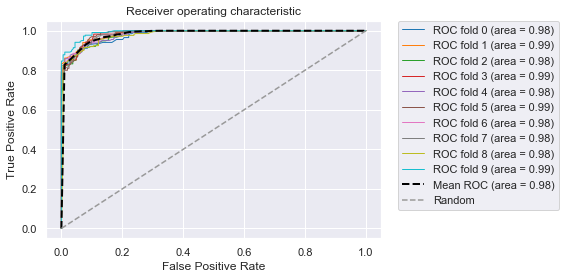

In [35]:
from abupy import ABuMLExecute
ABuMLExecute.plot_roc_estimator(estimator, train_x, train_y_classification)

### 10.3.3 通过决策树分类，绘制出决策图

这里需要安装dot graphviz，才能通过os.system("dot -T png graphviz.dot -o graphviz.png")生成png

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import os

estimator = DecisionTreeClassifier(max_depth=2, random_state=1)


def graphviz_tree(estimator, features, x, y):
    if not hasattr(estimator, 'tree_'):
        print('only tree can graphviz!')
        return

    estimator.fit(x, y)
    # 将决策模型导出graphviz.dot文件
    tree.export_graphviz(estimator.tree_, out_file='graphviz.dot',
                         feature_names=features)
    # 通过dot将模型绘制决策图，保存png
    os.system("dot -T png graphviz.dot -o graphviz.png")
# 这里会使用到特征的名称列pig_three_feature.columns[1:]
graphviz_tree(estimator, pig_three_feature.columns[1:], train_x,
              train_y_classification)

! open graphviz.png

only tree can graphviz!
The file /Users/admin/mwp/work/study/economy/stock/abu/ipython/graphviz.png does not exist.


## 特征的重要性排序及支持度评级

In [37]:
def importances_coef_pd(estimator):
    if hasattr(estimator, 'feature_importances_'):
        # 有feature_importances_的通过sort_values排序
        return pd.DataFrame(
            {'feature': list(pig_three_feature.columns[1:]),
            'importance': estimator.feature_importances_}).sort_values(
            'importance')

    elif hasattr(estimator, 'coef_'):
        # 有coef_的通过coef排序
        return pd.DataFrame(
            {"columns": list(pig_three_feature.columns)[1:],
             "coef": list(estimator.coef_.T)}).sort_values(
            'coef')
    else:
        print('estimator not hasattr feature_importances_ or coef_!')

# 使用随机森林分类器
estimator = RandomForestClassifier(n_estimators=100)
# 训练数据模型
estimator.fit(train_x, train_y_classification)
# 对训练后的模型特征的重要度进行判定，重要程度由小到大，表10-4所示
importances_coef_pd(estimator)

,feature,importance
5,feature_price_noise,0.0523
4,feature_volume_noise,0.0528
1,feature_volume_Change,0.0928
3,feature_date_week,0.0941
0,feature_price_change,0.1093
2,feature_sign,0.5986


In [38]:
from sklearn.feature_selection import RFE


def feature_selection(estimator, x, y):
    selector = RFE(estimator)
    selector.fit(x, y)
    print('RFE selection')
    print(pd.DataFrame(
        {'support': selector.support_, 'ranking': selector.ranking_},
        index=pig_three_feature.columns[1:]))


feature_selection(estimator, train_x, train_y_classification)

RFE selection
                       support  ranking
feature_price_change      True        1
feature_volume_Change     True        1
feature_sign              True        1
feature_date_week        False        2
feature_volume_noise     False        3
feature_price_noise      False        4


## 10.4 无监督机器学习

### 10.4.1 使用降维可视化数据

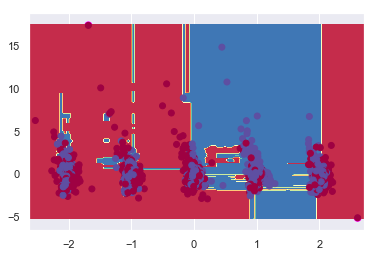

In [39]:
from sklearn.decomposition import PCA


def plot_decision_function(estimator, x, y):
    # pca进行降维，只保留2个特征序列
    pca_2n = PCA(n_components=2)
    x = pca_2n.fit_transform(x)

    # 进行训练
    estimator.fit(x, y)
    plt.scatter(x[:, 0], x[:, 1], c=y, s=50, cmap='spring')
    ABuMLExecute.plot_decision_boundary(
        lambda p_x: estimator.predict(p_x), x, y)


estimator = RandomForestClassifier(n_estimators=100)
plot_decision_function(estimator, train_x, train_y_classification)

### 10.4.2 猪老三使用聚类算法提高正确率

In [40]:
# 使用随机森林作为分类器
estimator = RandomForestClassifier(n_estimators=100)
estimator.fit(train_x, train_y_classification)
test_y_prdict_classification = estimator.predict(test_x)

print("accuracy = %.2f" % (
metrics.accuracy_score(test_y_classification,
                       test_y_prdict_classification)))

accuracy = 0.93


In [41]:
# 测试集feature即usFB的kl feature
pig_three_kmean_feature = kl_another_word_feature_test
# 测试集真实的涨跌结果test_y_classification
pig_three_kmean_feature['y'] = test_y_classification
# 使用刚刚的随机森林作为分类器的预测涨跌结果test_y_prdict_classification
pig_three_kmean_feature['y_prdict'] = test_y_prdict_classification
# 即生成一列新数据记录预测是否正确
pig_three_kmean_feature['y_same'] = np.where(
    pig_three_kmean_feature['y'] ==
    pig_three_kmean_feature['y_prdict'], 1, 0)
# 将feature中只保留刚刚得到的y_same
pig_three_kmean_feature = pig_three_kmean_feature.filter(['y_same'])

In [42]:
from sklearn.cluster import KMeans

# 使用刚刚得到的只有y_same列的数据赋值x_kmean
x_kmean = pig_three_kmean_feature.values
# n_clusters=2, 即只聚两类数据
kmean = KMeans(n_clusters=2) 
kmean.fit(x_kmean)
# 将聚类标签赋予新的一列cluster
pig_three_kmean_feature['cluster'] = kmean.predict(x_kmean)
# 将周几这个特征合并过来
pig_three_kmean_feature['feature_date_week'] = \
kl_another_word_feature_test['feature_date_week']
# 表10-5所示
pig_three_kmean_feature.tail()

,y_same,cluster,feature_date_week
2016-07-20,1,0,2
2016-07-21,1,0,3
2016-07-22,1,0,4
2016-07-25,1,0,0
2016-07-26,1,0,1


In [43]:
# 表10-6所示
pd.crosstab(pig_three_kmean_feature.feature_date_week, pig_three_kmean_feature.cluster)

cluster,0,1
feature_date_week,,
0,75,20
1,103,0
2,104,0
3,100,0
4,84,16


## 10.5 梦醒时分

In [44]:
from abupy import AbuML
# 通过x, y矩阵和特征的DataFrame对象组成AbuML
ml = AbuML(train_x, train_y_classification, pig_three_feature)
# 使用随机森林作为分类器
_ = ml.estimator.random_forest_classifier()

In [45]:
# 交织验证结果的正确率
ml.cross_val_accuracy_score()
# 特征的选择
ml.feature_selection()

RandomForestClassifier score mean: 0.9170554657268781
RFE selection
                       support  ranking
feature_price_change      True        1
feature_volume_Change     True        1
feature_sign              True        1
feature_date_week        False        2
feature_volume_noise     False        4
feature_price_noise      False        3


,support,ranking
feature_price_change,True,1
feature_volume_Change,True,1
feature_sign,True,1
feature_date_week,False,2
feature_volume_noise,False,4
feature_price_noise,False,3


### 10.5.1 回测中生成特征，切分训练测试集，成交买单快照

如下内容即不能使用沙盒环境, 建议对照阅读**abu量化文档－第十九节 数据源，第20节 美股交易UMP决策**。

In [46]:
abupy.env.disable_example_env_ipython()
from abupy import AbuMetricsBase, AbuFactorCloseAtrNStop, AbuFactorPreAtrNStop, AbuFactorAtrNStop, AbuFactorBuyBreak
from abupy import abu, EMarketDataFetchMode, EMarketTargetType, EStoreAbu, EMarketSourceType, EDataCacheType, ABuProgress
import ipywidgets

disable example env


所有获取的数据已经存放在百度云盘上，后面的章节使用的数据都是本节更新的数据，建议直接从云盘下载入库完毕的数据库，不需要从各个数据源再一个一个的下载数据进行入库，百度云地址如下：

[csv格式美股，A股，港股，币类，期货6年日k数据](https://pan.baidu.com/s/1geNZgqf) 密码: gvtr

下面数据存贮格式为hdf5数据，由于hdf5文件解压后非常大，还需要区分python版本，所以如果没有足够的存贮空间
特别是python2下，建议使用csv格式的缓存文件：

[mac系统python3 美股，A股，港股，币类，期货6年日k数据](https://pan.baidu.com/s/1o8sldNk) 密码: ecyp

[mac系统python2 A股6年日k数据: ](https://pan.baidu.com/s/1bptn25h) 密码: sid8

[mac系统python2 美股6年日k数据: ](https://pan.baidu.com/s/1geHR9Lp) 密码: uaww

[windows python3 美股，A股，港股，币类，期货6年日k数据](https://pan.baidu.com/s/1bzeVHO) 密码: 3cwe

[windows python2 A股6年日k数据: ](https://pan.baidu.com/s/1skZOe7N) 密码: 78mb

[windows python2 美股6年日k数据: ](https://pan.baidu.com/s/1i5MNzKx) 密码: 63r3

下载完毕上述数据后，hdf5解压得到df_kl.h5文件，csv解压得到csv文件夹，解压后放到下面路径下即可

In [47]:
if abupy.env.g_is_mac_os:
    !open $abupy.env.g_project_data_dir
else:
    !echo $abupy.env.g_project_data_dir

如果不想通过直接下载数据文件的方式，也可下面通过切换至腾讯数据源，然后进行美股数据全市场更新：

备注：耗时操作，大概需要运行15分钟左右，可以在做其它事情的时候运行

In [49]:
def tx_us():
    abupy.env.g_market_source = EMarketSourceType.E_MARKET_SOURCE_tx
    abupy.env.g_data_cache_type = EDataCacheType.E_DATA_CACHE_CSV
    abu.run_kl_update(start='2011-08-08', end='2017-08-08', market=EMarketTargetType.E_MARKET_TARGET_US, n_jobs=32)

# 避免使用notebook运行run all时运行不想执行的代码
_ = ipywidgets.interact_manual(tx_us)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

将数据读取模式设置为本地数据模式，即进行全市场回测时最合适的模式，运行效率高，且分类数据更新和交易回测。

In [50]:
abupy.env.g_data_fetch_mode = abupy.env.EMarketDataFetchMode.E_DATA_FETCH_FORCE_LOCAL

下面将回测市场设置为美股市场：

In [51]:
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_US

下面设置回测时切割训练集，测试集使用的切割比例参数，默认为10，即切割为10份，9份做为训练，1份做为测试，由于美股股票数量多，所以切割分为4份，3份做为训练集，1份做为测试集：

In [52]:
abupy.env.g_split_tt_n_folds = 4

下面通过env中的设置将回测中的symbols切分为回测训练集与回测测试集，且打开回测生成买入时刻特征开关：

详情请阅读ABuMarket模块

In [53]:
# 回测时生成买入时刻特征
abupy.env.g_enable_ml_feature = True
# 回测时将symbols切割分为训练集数据和测试集两份，使用训练集进行回测
abupy.env.g_enable_train_test_split = True

买入因子，卖出因子等依然使用相同的设置，如下所示：

In [54]:
# 初始化资金500万
read_cash = 5000000

# 买入因子依然延用向上突破因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak},
               {'xd': 42, 'class': AbuFactorBuyBreak}]

# 卖出因子继续使用上一节使用的因子
sell_factors = [
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0,
     'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]

In [55]:
# 每笔交易的买入基数资金设置为万分之15
abupy.beta.atr.g_atr_pos_base = 0.0015

在上面run_kl_update中更新了从2011-08-08至2017-08-08，由于在买入时刻生成特征，所以要保留一年的数据做为特征数据回测时段，所以下面的回测start使用2012-08-08至2017-08-08，即向后推了一年做回测：

下面开始回测，第一次运行select：run loop back，然后点击run select，如果已经回测过可select：load train data直接从缓存数据读取：

In [56]:
abu_result_tuple = None
def run_loop_back():
    global abu_result_tuple
    abu_result_tuple, _ = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   choice_symbols=None,
                                                   start='2012-08-08', end='2017-08-08')
    # 把运行的结果保存在本地，以便之后分析回测使用，保存回测结果数据代码如下所示
    abu.store_abu_result_tuple(abu_result_tuple, n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                               custom_name='train_us')
    ABuProgress.clear_output()

def run_load_train():
    global abu_result_tuple
    abu_result_tuple = abu.load_abu_result_tuple(n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                                                 custom_name='train_us')

def select(select):
    if select == 'run loop back':
        run_loop_back()
    else:
        run_load_train()

_ = ipywidgets.interact_manual(select, select=['run loop back', 'load train data'])

interactive(children=(Dropdown(description='select', options=('run loop back', 'load train data'), value='run …

买入后卖出的交易数量:89418
买入后尚未卖出的交易数量:2012
胜率:46.5220%
平均获利期望:8.4475%
平均亏损期望:-5.6229%
盈亏比:1.3312
策略收益: 61.3978%
基准收益: 111.5646%
策略年化收益: 12.2991%
基准年化收益: 22.3484%
策略买入成交比例:31.7084%
策略资金利用率比例:88.6240%
策略共执行1258个交易日


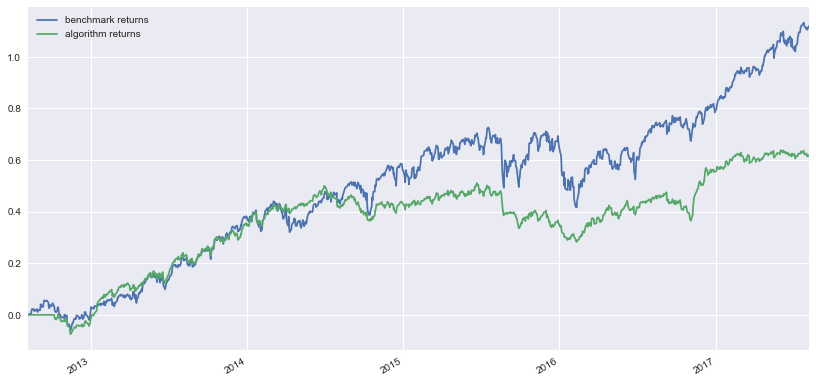

In [10]:
metrics_train = AbuMetricsBase(*abu_result_tuple)
metrics_train.fit_metrics()
metrics_train.plot_returns_cmp(only_show_returns=True)

下面通过env中设置使用刚才切分的测试集美股symbol，它使用pickle读取之前已经切割好的本地化测试集股票代码序列：

In [11]:
# 测试集回测时不生成买入时刻特征了，为了提高运行效率
abupy.env.g_enable_ml_feature = False
# 回测时使用切割好的测试数据
abupy.env.g_enable_last_split_test = True

提高g_atr_pos_base为0.007（因为默认切割训练集与测试集数据比例为4:1，所以提高g_atr_pos_base为之前的大概3-5倍都可以：

In [12]:
abupy.beta.atr.g_atr_pos_base = 0.007

下面开始回测，第一次运行select：run loop back，然后点击run select_test，如果已经回测过可select：load test data直接从缓存数据读取：

In [36]:
abu_result_tuple_test = None
def run_loop_back_test():
    global abu_result_tuple_test
    abu_result_tuple_test, _ = abu.run_loop_back(read_cash,
                                                 buy_factors,
                                                 sell_factors,
                                                 choice_symbols=None,
                                                 start='2012-08-08', end='2017-08-08')
    # 把运行的结果保存在本地，以便之后分析回测使用，保存回测结果数据代码如下所示
    abu.store_abu_result_tuple(abu_result_tuple_test, n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                               custom_name='test_us')
    ABuProgress.clear_output()

def run_load_test():
    global abu_result_tuple_test
    abu_result_tuple_test = abu.load_abu_result_tuple(n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                                                 custom_name='test_us')

def select_test(select):
    if select == 'run loop back':
        run_loop_back_test()
    else:
        run_load_test()

_ = ipywidgets.interact_manual(select_test, select=['run loop back', 'load test data'])

please wait! load_pickle....: /Users/Bailey/abu/data/cache/n5_test_us_capital
please wait! load_pickle....: /Users/Bailey/abu/data/cache/n5_test_us_benchmark


买入后卖出的交易数量:29786
买入后尚未卖出的交易数量:625
胜率:46.5420%
平均获利期望:8.4243%
平均亏损期望:-5.7298%
盈亏比:1.3117
策略收益: 63.2158%
基准收益: 111.5646%
策略年化收益: 12.6633%
基准年化收益: 22.3484%
策略买入成交比例:20.8674%
策略资金利用率比例:90.2922%
策略共执行1258个交易日


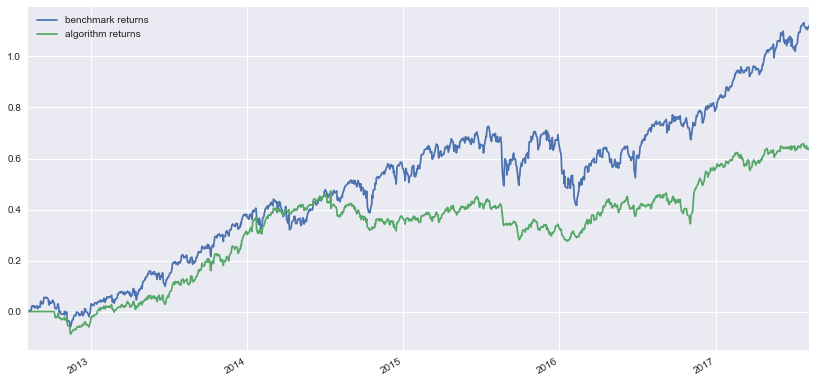

In [38]:
metrics_test = AbuMetricsBase(*abu_result_tuple_test)
metrics_test.fit_metrics()
metrics_test.plot_returns_cmp(only_show_returns=True)

如上在所有生成的结果中的orders_pd中添加了交易买入信号发出时刻的机器学习特征元素（由于g_enable_ml_feature的设置），如下输出所示的deg_ang21、price_rank90、 jump_up_power、wave_score1等等。

In [13]:
abu_result_tuple.orders_pd[abu_result_tuple.orders_pd.result != 0].head()

,buy_date,buy_price,buy_cnt,buy_factor,symbol,buy_pos,buy_type_str,expect_direction,sell_type_extra,sell_date,...,sell_wave_score1,sell_wave_score2,sell_wave_score3,sell_diff_up_days,sell_jump_down_power,sell_diff_down_days,sell_jump_up_power,profit_cg,profit_cg_hunder,keep_days
2012-10-08,20121008,10.260,794.0,AbuFactorBuyBreak:42,usKRG,AbuAtrPosition,call,1.0,AbuFactorCloseAtrNStop:close_atr_n=1.5,20121106,...,0.043,0.013,0.003,306.0,-3.308,126.0,1.754,0.0663,6.6277,29
2012-10-08,20121008,24.030,207.0,AbuFactorBuyBreak:42,usOPXA,AbuAtrPosition,call,1.0,AbuFactorCloseAtrNStop:close_atr_n=1.5,20121102,...,0.419,0.650,0.758,17.0,-1.142,244.0,1.407,-0.1051,-10.5078,25
2012-10-08,20121008,75.625,198.0,AbuFactorBuyBreak:42,usPM,AbuAtrPosition,call,1.0,AbuFactorAtrNStop:stop_loss=1.0,20121019,...,0.640,0.438,0.352,84.0,-1.427,0.0,1.272,-0.0617,-6.1686,11
2012-10-08,20121008,18.055,830.0,AbuFactorBuyBreak:42,usMBRG,AbuAtrPosition,call,1.0,AbuFactorAtrNStop:stop_loss=1.0,20121025,...,0.450,0.648,0.761,0.0,-2.274,208.0,0.000,-0.0626,-6.2587,17
2012-10-08,20121008,34.990,428.0,AbuFactorBuyBreak:42,usVAC,AbuAtrPosition,call,1.0,AbuFactorCloseAtrNStop:close_atr_n=1.5,20121105,...,-0.153,-0.073,0.034,126.0,-2.050,123.0,3.033,-0.0080,-0.8002,28


### 10.5.2 基于特征的交易预测

In [14]:
from abupy.UmpBu.ABuUmpMainMul import UmpMulFiter
mul = UmpMulFiter(orders_pd=abu_result_tuple.orders_pd, scaler=False)
mul.df.head()

,result,buy_deg_ang21,buy_price_rank252,buy_wave_score3,buy_atr_std
2012-10-08,1,1.379,0.996,0.114,0.769
2012-10-08,0,0.782,0.542,1.044,0.721
2012-10-08,0,4.072,1.000,0.121,0.909
2012-10-08,0,4.160,1.000,0.855,0.752
2012-10-08,0,6.441,1.000,0.251,0.481


In [17]:
%%time

# 默认使用svm作为分类器, 改分类器决策树分类
mul.estimator.decision_tree_classifier()
mul.cross_val_accuracy_score()

DecisionTreeClassifier score mean: 0.534780469413376


CPU times: user 1.02 s, sys: 14.1 ms, total: 1.04 s
Wall time: 1.17 s


In [18]:
%%time

# 默认使用svm作为分类器, 改分类器knn
mul.estimator.knn_classifier()
mul.cross_val_accuracy_score()

KNeighborsClassifier score mean: 0.4986468301562593


CPU times: user 2.79 s, sys: 18.7 ms, total: 2.8 s
Wall time: 3.44 s


下面使用历史拟合角度特征来实验一下:

In [27]:
from abupy.UmpBu.ABuUmpMainBase import UmpDegFiter
deg = UmpDegFiter(orders_pd=abu_result_tuple.orders_pd)
deg.df.head()

,result,buy_deg_ang42,buy_deg_ang252,buy_deg_ang60,buy_deg_ang21
2012-10-08,1,6.235,30.437,7.471,1.379
2012-10-08,0,19.307,-29.469,10.680,0.782
2012-10-08,0,0.273,20.166,1.403,4.072
2012-10-08,0,6.565,10.223,5.845,4.160
2012-10-08,0,11.594,30.253,12.118,6.441


下面使用GradientBoosting:

In [26]:
%%time
# 分类器使用GradientBoosting
deg.estimator.xgb_classifier()
deg.cross_val_accuracy_score()

GradientBoostingClassifier score mean: 0.525867081770315


CPU times: user 36.9 s, sys: 466 ms, total: 37.3 s
Wall time: 37.4 s


array([ 0.5186,  0.531 ,  0.534 ,  0.5103,  0.5305,  0.5243,  0.5248,
        0.5305,  0.5375,  0.5172])

下面使用adaboost:

In [31]:
# 分类器使用adaboost
deg.estimator.adaboost_classifier(base_estimator=None)
deg.cross_val_accuracy_score()

AdaBoostClassifier score mean: 0.5230600684400639


array([ 0.5168,  0.5192,  0.5335,  0.5076,  0.5328,  0.5186,  0.5207,
        0.5311,  0.5347,  0.5157])

这个效果似乎不错，但别高兴太早，看看混淆矩阵的分布， 可以发现，它正确率高的原因是模型大多数的预测都是0，典型非均衡结果预测

In [32]:
deg().train_test_split_xy()

x-y:(89418, 4)-(89418,)
train_x-train_y:(80476, 4)-(80476,)
test_x-test_y:(8942, 4)-(8942,)
accuracy = 0.53
precision_score = 0.50
recall_score = 0.06
          Predicted
         |  0  |  1  |
         |-----|-----|
       0 | 4509 | 234 |
Actual   |-----|-----|
       1 | 3967 | 232 |
         |-----|-----|
             precision    recall  f1-score   support

        0.0       0.53      0.95      0.68      4743
        1.0       0.50      0.06      0.10      4199

avg / total       0.52      0.53      0.41      8942



下面使用更多的特征来实验一下，特征如输出所示:

In [36]:
from abupy.UmpBu.ABuUmpMainFull import UmpFullFiter
full = UmpFullFiter(orders_pd=abu_result_tuple.orders_pd)
full.estimator.logistic_classifier()
full.df.head()

,result,buy_deg_ang42,buy_deg_ang252,buy_deg_ang60,buy_deg_ang21,buy_price_rank120,buy_price_rank90,buy_price_rank60,buy_price_rank252,buy_wave_score1,buy_wave_score2,buy_wave_score3,buy_atr_std,buy_diff_up_days,buy_jump_down_power,buy_diff_down_days,buy_jump_up_power
2012-10-08,1,6.235,30.437,7.471,1.379,0.992,0.989,1.000,0.996,0.184,0.134,0.114,0.769,0,-3.018,95,0.000
2012-10-08,0,19.307,-29.469,10.680,0.782,0.996,0.994,0.992,0.542,0.620,0.919,1.044,0.721,23,0.000,0,1.377
2012-10-08,0,0.273,20.166,1.403,4.072,1.000,1.000,1.000,1.000,0.174,0.153,0.121,0.909,71,-1.087,126,1.646
2012-10-08,0,6.565,10.223,5.845,4.160,1.000,1.000,1.000,1.000,0.557,0.754,0.855,0.752,0,-3.122,189,0.000
2012-10-08,0,11.594,30.253,12.118,6.441,1.000,1.000,1.000,1.000,-0.070,0.144,0.251,0.481,98,-2.050,95,3.033


In [37]:
full.cross_val_accuracy_score()

LogisticRegression score mean: 0.525777848996541


array([ 0.5193,  0.5305,  0.5315,  0.529 ,  0.5396,  0.4855,  0.5295,
        0.5365,  0.5287,  0.5276])

如下使用随机森林尝试，结果基本一样, 且运行速度会比较慢：

In [ ]:
%%time

# 分类器使用随机森林
full.estimator.random_forest_classifier()
full.cross_val_accuracy_score()

### 10.5.3 基于深度学习的交易预测

### 10.5.4 预测市场的混沌，混沌市场的预测